In [1]:
import pandas as pd # moduels used for project
import numpy as np
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans
from env import get_db_url
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w
import explore as exp
from wrangle import clean_zillow
from wrangle import create_features
from wrangle import train_validate_test_split
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import model
from model import  select_kbest
# Vis imports to make things look pretty 
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.style as style 
style.available
style.use('seaborn-talk') #sets the size of the charts
style.use('seaborn-colorblind') #sets color of charts
from wrangle import wrangle_zillow


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# <span style="color:maroon;"> Hypotheses And Questions  </span>

1.Fail to reject the null hypothesis // home_age and logerror.
There is a linear relationship.
Although, it is a negative weak one.
    
2.Reject null statment: No correlation between lot_sqft and logerror.
There is a linear relationship.
Although, it is a positive weak one.

3.Fail to reject the null hypothesis // No correlation between home_value and logerror.

    
    
-LA:  0.014516765820273388

-Orange:  0.01786707488534417

-Ventura: 0.013923148212340804 

4. All three counties rejected the null hypothiesis

5. I would like to know the skews and look of my targeted data 




In [2]:
df = w.zillow17() # data file 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [4]:
df = w.wrangle_zillow()

Prepare Summary: 
- Dropped: 
- 45 columns and 4323 rows 
- WHY DID I DROP ?! 
I dropped nulls columns that had more then 60% of nulls and dropped rows that had 70% of nulls because I could not get the missing information from other variables or impute the missing values without high skew or other problems.I also dropped columns that contained information that was repeated or was not usefull and dropped columns that contained information I would not be using in our models. 
Outliers: 

I handled outliers in taxvaluedollarcnt by dropping values more then $5 million 
- I handled outliers in calculatedfinishedsquarefeet by dropping values less then 500 sqft and more then 12500 sqft 
- Remaining missing values: 
- lotsizesquarefeet missing values were filled with median numbers 
- buildingqualitytypeid missing values were filled with median numbers 
- remaining missing values were dropped as they where not usefull 
- Renamed columns: 
- 9 columns renamed to accurately represent the data they contain for ease and sanity 
- Ex). calculatedfinishedsquarefeet to sqft 
- New features: - New features created: home_age, county, logerror_quartiles 
-Split: 
- dataset was split into 70% Train, 20% Validate, 10% Test

In [5]:
def train_validate_test_split(df, target, seed): # used as a follow Function
    '''
    spilts our data  into train, validate, test
    '''
    # Train, Validate, and test
    train_and_validate, test = train_test_split(
        df, test_size=0.2, random_state=seed)
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=seed)
    # Split with X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    X_test = test.drop(columns=[target])
    y_test = test[target]
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test  

In [6]:
def Standard_Scaler(X_train, X_validate, X_test): # used as a follow Function
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs
    """
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

Exploring The Clean Data
1.Question what are the skews of my explored data
are Fips relevant to the issue of logerror
is there anything that stands out in property_quality
is there anything that stands out in home_age

In [7]:
dummies = pd.get_dummies(df.county)  # created dummy files 
dummies.columns = ['LA', 'Orange', 'Ventura']
df = pd.concat([df, dummies], axis=1)

In [8]:
new = df[['LA', 'Orange', 'Ventura','fips','latitude', 'longitude', 'sqft', 'lot_sqft', 'zip_code', 'property_quality', 'home_age', 'logerror', 'structure_value', 'bedrooms' , 'bathrooms' , 'land_value']].copy()

In [9]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test_split( new, 'logerror', 123)

In [10]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Standard_Scaler(X_train, X_validate, X_test)

In [11]:
def explore_univariate(train, cat_vars, quant_vars): # used as a follow Function
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)
        
def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        explore_bivariate_quant(train, target, quant)

def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue='target')
    plt.show()
    plot_all_continuous_vars(train, 'target', quant_vars)
    plt.show()    



In [12]:
def explore_univariate_quant(train, quant_var): # used as a follow Function
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='maroon')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats

In [13]:
train['structure_dollar_per_sqft'] = train.structure_value / train.sqft
train['land_dollar_per_sqft'] = train.land_value / train.lot_sqft
train['bed_bath_ratio'] = train.bedrooms / train.bathrooms

In [14]:
binary_vars = ['LA', 'Orange', 'Ventura']
cat_vars = []
quant_var = ['fips', 'latitude', 'longitude', 'sqft',
       'lot_sqft', 'zip_code', 'property_quality', 'home_age','structure_value', 'bedrooms' , 'bathrooms' , 'land_value'
            ,'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio' ]
continuous_target = 'logerror'
categorical_target = 'logerror'

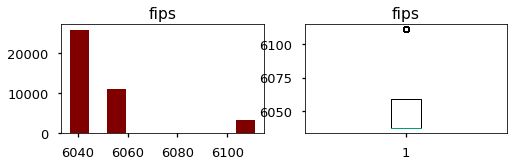

count    40217.000000
mean      6049.276351
std         21.040147
min       6037.000000
25%       6037.000000
50%       6037.000000
75%       6059.000000
max       6111.000000
Name: fips, dtype: float64


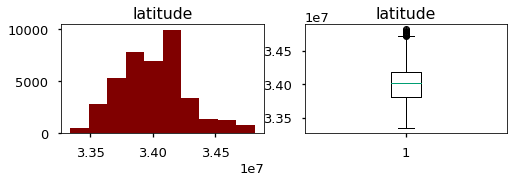

count    4.021700e+04
mean     3.400741e+07
std      2.671053e+05
min      3.333953e+07
25%      3.381196e+07
50%      3.402078e+07
75%      3.417650e+07
max      3.481877e+07
Name: latitude, dtype: float64


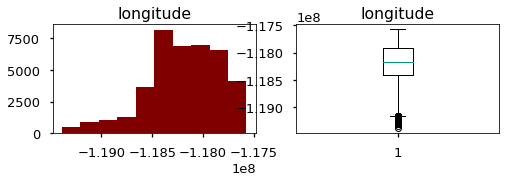

count    4.021700e+04
mean    -1.181994e+08
std      3.639335e+05
min     -1.193883e+08
25%     -1.184165e+08
50%     -1.181671e+08
75%     -1.179168e+08
max     -1.175728e+08
Name: longitude, dtype: float64


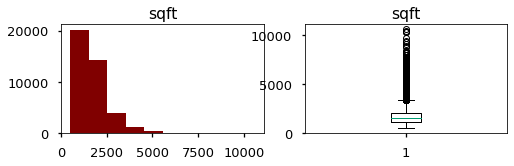

count    40217.000000
mean      1733.628714
std        861.174436
min        501.000000
25%       1171.000000
50%       1507.000000
75%       2044.000000
max      10605.000000
Name: sqft, dtype: float64


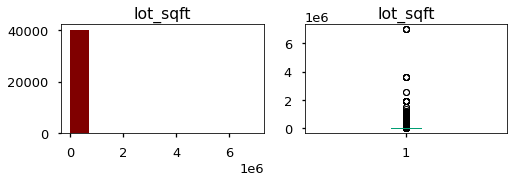

count    4.021700e+04
mean     2.816415e+04
std      1.253648e+05
min      2.360000e+02
25%      5.983000e+03
50%      7.265000e+03
75%      1.058800e+04
max      6.971010e+06
Name: lot_sqft, dtype: float64


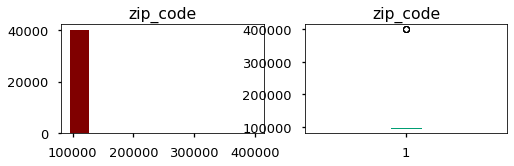

count     40217.000000
mean      96586.871298
std        3050.899556
min       95982.000000
25%       96208.000000
50%       96410.000000
75%       96989.000000
max      399675.000000
Name: zip_code, dtype: float64


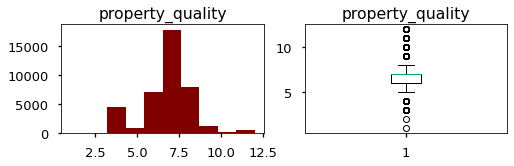

count    40217.000000
mean         6.753637
std          1.346508
min          1.000000
25%          6.000000
50%          7.000000
75%          7.000000
max         12.000000
Name: property_quality, dtype: float64


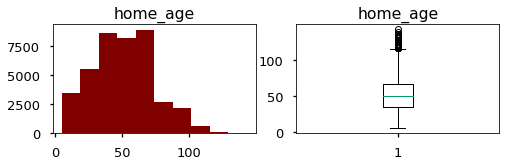

count    40217.000000
mean        51.419673
std         22.929058
min          5.000000
25%         34.000000
50%         50.000000
75%         67.000000
max        143.000000
Name: home_age, dtype: float64


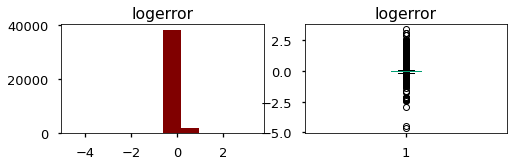

count    40217.000000
mean         0.015390
std          0.162298
min         -4.655420
25%         -0.023779
50%          0.006473
75%          0.037751
max          3.394544
Name: logerror, dtype: float64


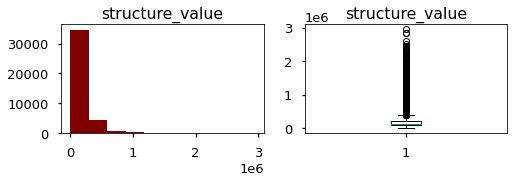

count    4.021700e+04
mean     1.813101e+05
std      1.783296e+05
min      1.480000e+02
25%      8.400000e+04
50%      1.347120e+05
75%      2.139880e+05
max      2.943209e+06
Name: structure_value, dtype: float64


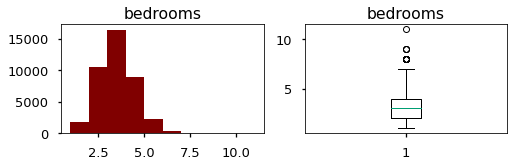

count    40217.000000
mean         3.008852
std          0.989914
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64


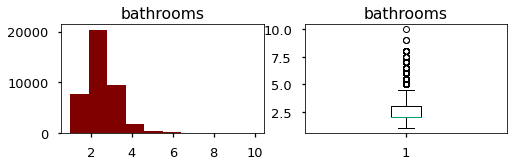

count    40217.000000
mean         2.269053
std          0.914743
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: bathrooms, dtype: float64


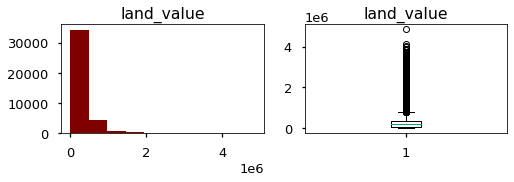

count    4.021700e+04
mean     2.837746e+05
std      3.265030e+05
min      1.196000e+03
25%      8.338700e+04
50%      2.030890e+05
75%      3.620000e+05
max      4.847224e+06
Name: land_value, dtype: float64


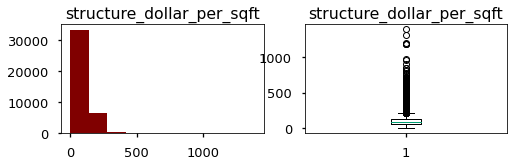

count    40217.000000
mean        99.532276
std         59.399594
min          0.039833
25%         63.079227
50%         91.724350
75%        124.075276
max       1386.370588
Name: structure_dollar_per_sqft, dtype: float64


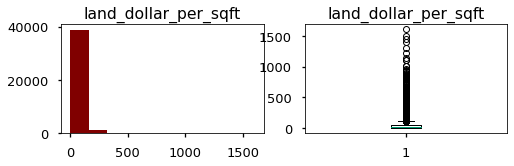

count    40217.000000
mean        41.055693
std         60.780846
min          0.003805
25%          6.341829
50%         25.492223
75%         51.983493
max       1604.525311
Name: land_dollar_per_sqft, dtype: float64


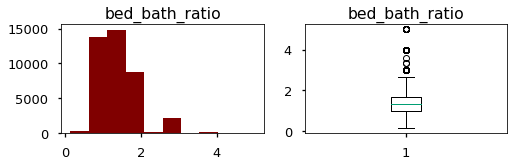

count    40217.000000
mean         1.450311
std          0.565171
min          0.133333
25%          1.000000
50%          1.333333
75%          1.666667
max          5.000000
Name: bed_bath_ratio, dtype: float64


In [15]:
cat_vars = []
quant_vars = ['fips', 'latitude', 'longitude', 'sqft',
       'lot_sqft', 'zip_code', 'property_quality', 'home_age', 'logerror','structure_value', 'bedrooms' , 'bathrooms' , 'land_value','structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio']

explore_univariate(train, cat_vars, quant_vars)

<div class="alert alert-block alert-warning">   <span style="color:maroon;">

# Information From Generated Graphs: 
<span style="color:black;">

    
- fips has a right skew, with the tip at LA
- Latitude is centered, probably not that important 
- Longitude has a left skew 
- sqft has a right skew 
- Hard to tell but i think lot_sqft will have a right skew  
- Zip code hard to tell still graph may be right skew 
- property_quality center 
- Home_age is a right skew 
- Logerror is center 
- Structure_value is a right skew 
- Bedrooms looks to be right skew 
- Bathrooms looks to be right skew 
- Land_value is a right skew 
- structure_dollar_per_sqft looks to be right skew 
- land_dollar_per_sqft is slim but probably is a right skew 
- bed_bath_ratio is a right skew 

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

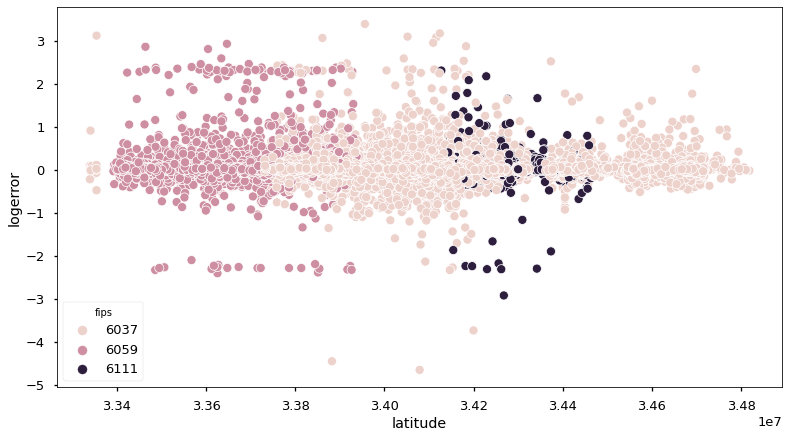

In [16]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='latitude', y='logerror', hue='fips')

<AxesSubplot:xlabel='longitude', ylabel='logerror'>

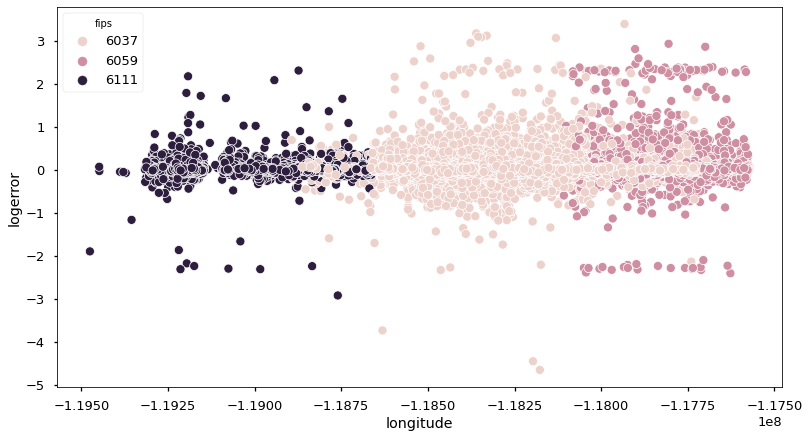

In [17]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='longitude', y='logerror', hue='fips')

Hypotheses testing
1.Fail to reject the null hypothesis // home_age and logerror. There is a linear relationship. Although, it is a negative weak one.
2.Reject null statment: No correlation between lot_sqft and logerror. There is a linear relationship. Although, it is a positive weak one.
3.Fail to reject the null hypothesis // No correlation between home_value and logerror.
All three counties rejected the null hypothiesis
Is logerror diffrent in each county
Properties of LA vs Orange
Properties of LA vs Ventura
Properties of Orange vs Ventura
-LA: 0.014516765820273388
-Orange: 0.01786707488534417
-Ventura: 0.013923148212340804

In [18]:
nullh = "No correlation between home_age and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between home_age and logerror."

#the feature you are testing
x1 = X_train_scaled.home_age

#against your target
y1 = y_train

In [19]:
def correlation_test(nullh, alth, x, y): # used as a follow Function 
    '''
    correlation_test will take in two arguments and 
    - plot a scatterplot of them
    - test the correlation
    return: the correlation coefficient, p, and if there is a linear relationship.
    '''
    
    splot = plt.scatter(x, y, cmap = 'Purples', c='maroon' )
    
    null_hypothesis = nullh
    alternative_hypothesis = alth
    
    confidence_level = .95
    a = 1 - confidence_level 
    
    corr, p = stats.pearsonr(x, y)

    if p < a:
        print(f"Reject null statment: {null_hypothesis}")
        print("There is a linear relationship.")
        if 0 < corr < .6:
            print("Although, it is a positive weak one.")
        elif .6 < corr < 1:
            print("That is a stronger positive correlation.")
        elif -.6 < corr < 0:
            print("Although, it is a negative weak one.")
        elif -1 < corr < -.6:
            print("That is a stronger negative correlation.")
        
    else : 
        print("Fail to reject the null hypothesis.")
        
    print(f"""
    Correlation Coefficient: {corr}
    p: {p}
    
    """)
    return splot

Fail to reject the null hypothesis.

    Correlation Coefficient: -0.009091686955585479
    p: 0.06826644862171057
    
    


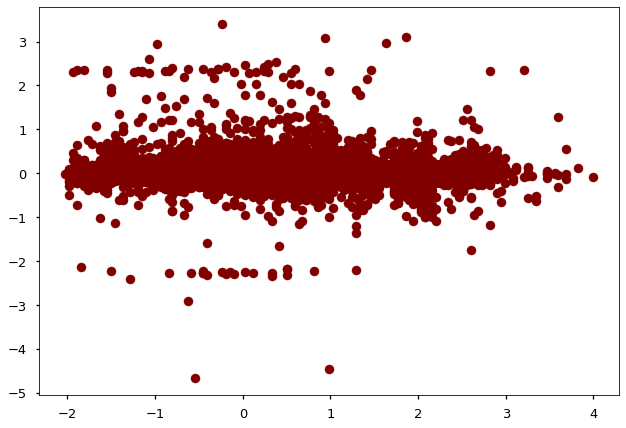

In [20]:
# Fail to reject the null hypothesis // home_age and logerror. There is a linear relationship. Although, it is a negative weak one.
correlation_test(nullh, alth, x1, y1)

In [21]:
nullh = "No correlation between lot_sqft and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between lot_sqft and logerror."

#the feature you are testing
x2 = X_train_scaled.lot_sqft

#against your target
y2 = y_train

Reject null statment: No correlation between lot_sqft and logerror.
There is a linear relationship.
Although, it is a positive weak one.

    Correlation Coefficient: 0.012872169213528831
    p: 0.009839073124819048
    
    


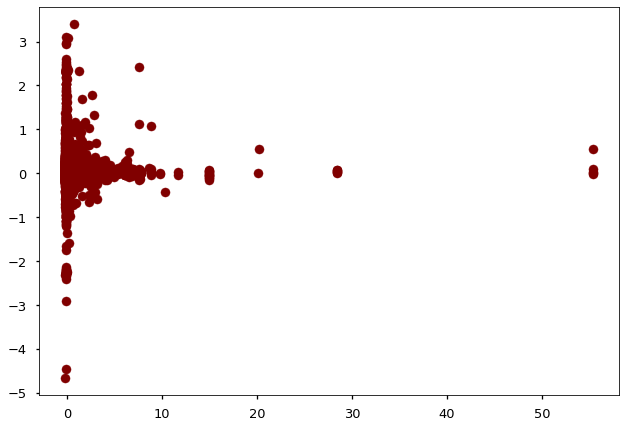

In [22]:
correlation_test(nullh, alth, x2, y2)

In [23]:
nullh = "No correlation between land_value and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between land_value and logerror."

#the feature you are testing
x3 = X_train_scaled.land_value

#against your target
y3 = y_train

Fail to reject the null hypothesis.

    Correlation Coefficient: -0.002359023235530234
    p: 0.6361642093651477
    
    


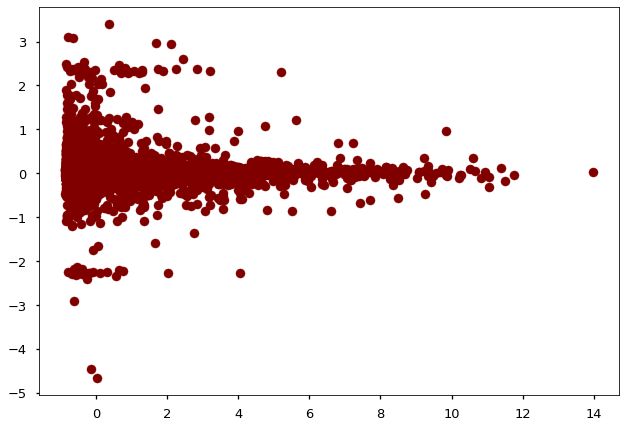

In [24]:
correlation_test(nullh, alth, x3, y3)

In [25]:
conf_interval = .95 # desired confidence interval
alpha = 1 - conf_interval

In [26]:
LA = train[train.LA == 1].logerror
Orange = train[train.Orange == 1].logerror
Ventura = train[train.Ventura == 1].logerror

In [27]:
mean_log_la = LA.mean()
mean_log_orange = Orange.mean()
mean_log_ventura = Ventura.mean()

In [28]:
print('LA: ', mean_log_la)
print('Orange: ', mean_log_orange)
print('Ventura:', mean_log_ventura)

LA:  0.014516765820273388
Orange:  0.01786707488534417
Ventura: 0.013923148212340804


In [29]:
#correlation test summary
def stat_summary(p):
    if p < alpha:
        print(f'Pvalue is: {p} is less than alpha: {alpha}')
        print("Reject the null hypothesis because there is a significant difference present")
    else:
        print(f'Pvalue is: {p} is greater than alpha: {alpha}')
        print("We fail to reject the null hypothesis because there is no significant difference present")

In [30]:
t, p = stats.ttest_ind(LA, Orange, equal_var=False)

## Logerror vs LA and Orange county

In [31]:
t, p # looking at testing numbers 

(-1.7031191104734367, 0.08856271829227355)

In [32]:
stat_summary(p) # Pvalue is: 0.08856271829227355 is greater than alpha: 0.050000000000000044
#We fail to reject the null hypothesis because there is no significant difference present

Pvalue is: 0.08856271829227355 is greater than alpha: 0.050000000000000044
We fail to reject the null hypothesis because there is no significant difference present


## Logerror vs Orange and Ventura County

In [33]:
t, p = stats.ttest_ind(Orange, Ventura, equal_var=False) #looking at testing numbers 
t,p

(1.2275702335554781, 0.21965415832601334)

In [34]:
stat_summary(p) # Pvalue is: 0.21965415832601334 is greater than alpha: 0.050000000000000044
 #We fail to reject the null hypothesis because there is no significant difference present

Pvalue is: 0.21965415832601334 is greater than alpha: 0.050000000000000044
We fail to reject the null hypothesis because there is no significant difference present


## Logerror vs LA and Ventura County 

In [35]:
t, p = stats.ttest_ind(LA, Ventura, equal_var=False) # # looking at testing numbers 
t,p

(0.20602286996960875, 0.8367828703309689)

In [36]:
stat_summary(p) # Pvalue is: 0.8367828703309689 is greater than alpha: 0.050000000000000044
 #We fail to reject the null hypothesis because there is no significant difference present

Pvalue is: 0.8367828703309689 is greater than alpha: 0.050000000000000044
We fail to reject the null hypothesis because there is no significant difference present


## <span style="color:maroon;">All Five Hypotheses And Questions have been answered please refer to the top   </span> 